In [1]:
import phoebe
from spice.models.binary import Binary
from spice.models.mesh_model import IcosphereModel
from spice.models.mesh_transform import transform
from spice.models.phoebe_utils import PhoebeConfig
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from spice.spectrum import simulate_observed_flux
from transformer_payne import Blackbody
import jax.numpy as jnp
from phoebe.parameters.dataset import _mesh_columns
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')

In [151]:
from spice.models.mesh_view import get_mesh_view


def default_icosphere():
    return get_mesh_view(IcosphereModel.construct(1000, 1., 1., [5700, 0.], ['teff', 'abun']), jnp.array([0., 1., 0.]))
body1 = default_icosphere()

body2 = transform(default_icosphere(), jnp.array([0.75, 1., 0.]))

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:225: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [152]:
from spice.models.mesh_view import Grid


grid = Grid.construct(body1, body2, 10)

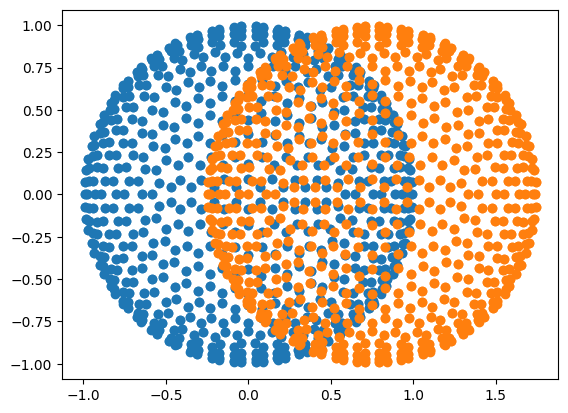

In [153]:
import matplotlib.pyplot as plt

plt.plot(body1.centers[:, 0], body1.centers[:, 2], 'o')
plt.plot(body2.centers[:, 0], body2.centers[:, 2], 'o')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


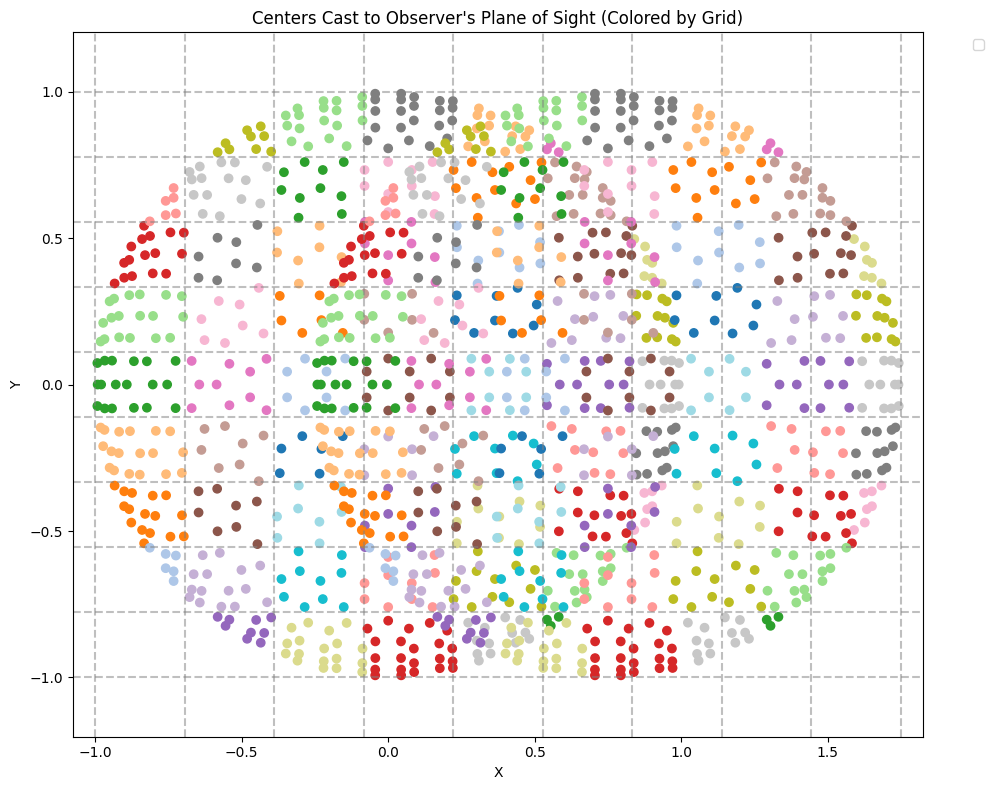

Shape of body1 cast centers: (1280, 2)
Shape of body2 cast centers: (1280, 2)


In [154]:
from functools import partial
import jax
from spice.geometry.utils import append_value_to_last_nan
from spice.models.mesh_model import MeshModel
from spice.models.mesh_view import create_grid_dictionaries, get_grid_index, get_neighbouring, total_visible_area
from spice.models.utils import cast_to_normal_plane
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Define the line-of-sight vector
los_vector = jnp.array([0., 1., 0.])  # Assuming the observer is looking along the y-axis

# Rewrite the cast_to_normal_plane function
def improved_cast_to_normal_plane(vectors, los_vector):
    """Cast 3D vectors to a 2D plane determined by the line-of-sight vector"""
    # Calculate the normal vector from the line-of-sight vector
    n = los_vector / jnp.linalg.norm(los_vector)
    
    # Create two orthogonal vectors in the plane perpendicular to the los_vector
    v1 = jnp.array([n[1], -n[0], 0])
    v1 = v1 / jnp.linalg.norm(v1)
    v2 = jnp.cross(n, v1)
    
    # Project the vectors onto the plane
    x = jnp.dot(vectors, v1)
    y = jnp.dot(vectors, v2)
    
    return jnp.column_stack((x, y))

# Cast the centers of body1 and body2 to the normal plane
body1_cast_centers = improved_cast_to_normal_plane(body1.centers, los_vector)
body2_cast_centers = improved_cast_to_normal_plane(body2.centers, los_vector)

@jax.jit
def improved_assign_element_to_grid(i: int, carry, m: MeshModel):
    def assign_element_to_grid1_pos_mu(i: int, carry):
        grid, grid_points, reverse_grid = carry
        cast_centers = improved_cast_to_normal_plane(body1.centers, los_vector)
        grid_index_x, grid_index_y = get_grid_index(grid, cast_centers[i])
        grid_points = grid_points.at[grid_index_x, grid_index_y].set(
            append_value_to_last_nan(grid_points[grid_index_x, grid_index_y], i))
        reverse_grid = reverse_grid.at[i].set(jnp.array([grid_index_x, grid_index_y]))
        return grid, grid_points, reverse_grid

    def assign_element_to_grid1_neg_mu(i: int, carry):
        grid, grid_points, reverse_grid = carry
        return grid, grid_points, reverse_grid.at[i].set(jnp.array([jnp.nan, jnp.nan]))

    return jax.lax.cond(jnp.all(m.mus[i] > 0),
                        assign_element_to_grid1_pos_mu,
                        assign_element_to_grid1_neg_mu,
                        i, carry)


@partial(jax.jit, static_argnums=(2,))
def improved_create_grid_dictionaries(m1: MeshModel, m2: MeshModel, grid: Grid):
    grids_m1 = jnp.nan * jnp.ones((grid.x.shape[0], grid.y.shape[0], grid.n_points_m1))
    reverse_grids_m1 = jnp.nan * jnp.ones((grid.n_centers_m1, 2))
    grids_m2 = jnp.nan * jnp.ones((grid.x.shape[0], grid.y.shape[0], grid.n_points_m2))
    reverse_grids_m2 = jnp.nan * jnp.ones((grid.n_centers_m2, 2))
    
    cast_centers1 = improved_cast_to_normal_plane(body1.centers, los_vector)
    
    cast_centers2 = improved_cast_to_normal_plane(body1.centers, los_vector)

    return (
        jax.lax.fori_loop(0, len(cast_centers1), lambda i, c: improved_assign_element_to_grid(i, c, m1),
                          (grid, grids_m1, reverse_grids_m1)),
        jax.lax.fori_loop(0, len(cast_centers2), lambda i, c: improved_assign_element_to_grid(i, c, m2),
                          (grid, grids_m2, reverse_grids_m2))
    )

# Create grid dictionaries
(_, grids_m1, reverse_grids_m1), (_, grids_m2, reverse_grids_m2) = improved_create_grid_dictionaries(body1, body2, grid)
reverse_grids_m1 = jnp.nan_to_num(reverse_grids_m1, -1)
reverse_grids_m2 = jnp.nan_to_num(reverse_grids_m2, -1)
# Create a colormap
# Create a colormap for the categories in reverse_grids_m1 and reverse_grids_m2
# Convert pairs of numbers to tuples for unique categories
unique_categories = np.unique(np.vstack((reverse_grids_m1, reverse_grids_m2)), axis=0)
n_categories = len(unique_categories)
cmap = plt.get_cmap('tab20')
category_colors = {tuple(cat): cmap(i % 20) for i, cat in enumerate(unique_categories)}

# Plot the cast centers with colors based on grid allocation
plt.figure(figsize=(10, 8))

# for category in unique_categories:
#     mask_m1 = np.all(reverse_grids_m1 == category, axis=1)
#     if np.any(mask_m1):
#         plt.scatter(body1_cast_centers[mask_m1, 0], body1_cast_centers[mask_m1, 1], 
#                     label=f'Body1 Grid {tuple(category)}', alpha=0.7, 
#                     color=category_colors[tuple(category)])

#     mask_m2 = np.all(reverse_grids_m2 == category, axis=1)
#     if np.any(mask_m2):
#         plt.scatter(body2_cast_centers[mask_m2, 0], body2_cast_centers[mask_m2, 1], 
#                     label=f'Body2 Grid {tuple(category)}', alpha=0.7, 
#                     color=category_colors[tuple(category)])

mus1 = body1.mus > 0
plt.scatter(body1_cast_centers[mus1, 0], body1_cast_centers[mus1, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m1[mus1]])

mus2 = body2.mus > 0
plt.scatter(body2_cast_centers[mus2, 0], body2_cast_centers[mus2, 1],
            c=[category_colors[tuple([int(x[0]), int(x[1])])] for x in reverse_grids_m2[mus2]])
    
for x in grid.x:
    plt.axvline(x, color='gray', linestyle='--', alpha=0.5)
for y in grid.y:
    plt.axhline(y, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Centers Cast to Observer\'s Plane of Sight (Colored by Grid)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print the shape of the cast centers to verify
print("Shape of body1 cast centers:", body1_cast_centers.shape)
print("Shape of body2 cast centers:", body2_cast_centers.shape)


In [155]:
def improved_resolve_occlusion_for_face(m1, m2, face_index: int, grid: Grid):
    (_, _, reverse_grids_m1), (_, grids_m2, _) = improved_create_grid_dictionaries(m1, m2, grid)
    m1_cast_vertices = improved_cast_to_normal_plane(m1.vertices, m1.los_vector)
    m2_cast_vertices = improved_cast_to_normal_plane(m2.vertices, m2.los_vector)
    ix, iy = jnp.nan_to_num(reverse_grids_m1[face_index], reverse_grids_m1.shape[0] + 1).astype(int)
    grid_neighbours = get_neighbouring(ix, iy)
    points_in_grid = (grids_m2[grid_neighbours[:, 0], grid_neighbours[:, 1]]).flatten()
    points_mask = jnp.where(jnp.isnan(points_in_grid), 0., 1.) * (m1.mus[face_index] > 0).astype(float)
    return jnp.sum(total_visible_area(m1_cast_vertices[m1.faces[face_index].astype(int)],
                                      m2_cast_vertices[m2.faces[points_in_grid.astype(int)].astype(int)]) * points_mask)


v_improved_resolve_occlusion_for_face = jax.jit(jax.vmap(improved_resolve_occlusion_for_face, in_axes=(None, None, 0, None)),
                                       static_argnums=(3,))


@partial(jax.jit, static_argnums=(2,))
def improved_resolve_occlusion(m1: MeshModel, m2: MeshModel, grid: Grid) -> MeshModel:
    """Calculate the occlusion of m1 by m2

    Args:
        m1 (MeshModel): occluded mesh model
        m2 (MeshModel): occluding mesh model
        grid (Grid): grid for calculation optimization

    Returns:
        MeshModel: m1 with updated visible areas
    """
    o = v_improved_resolve_occlusion_for_face(m1, m2, jnp.arange(len(m1.faces)), grid)
    return m1._replace(
        occluded_areas=o
    )

In [149]:
body1_occluded = improved_resolve_occlusion(body1, body2, grid)

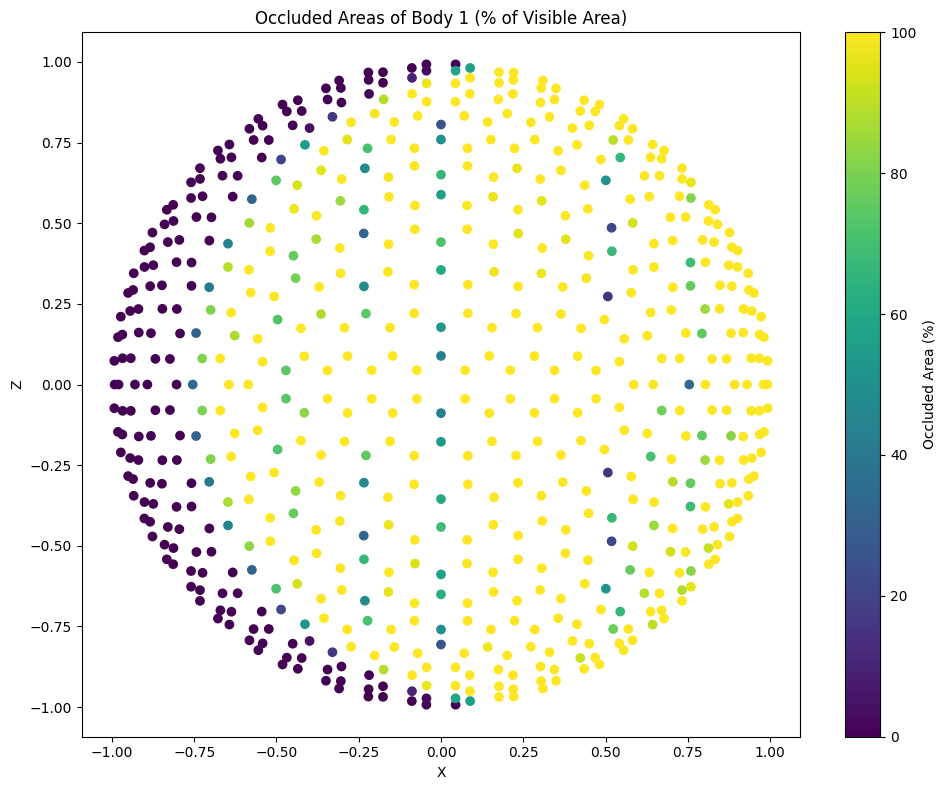

In [150]:
# Calculate occluded areas as a percentage of total visible area
occluded_percentage = body1_occluded.occluded_areas / body1_occluded.cast_areas * 100

# Plot occluded areas as a percentage for body1
plt.figure(figsize=(10, 8))
b_mu = body1_occluded.mus > 0
plt.scatter(body1_occluded.centers[b_mu, 0], body1_occluded.centers[b_mu, 2], c=occluded_percentage[b_mu], cmap='viridis')
plt.colorbar(label='Occluded Area (%)')
plt.title('Occluded Areas of Body 1 (% of Visible Area)')
plt.xlabel('X')
plt.ylabel('Z')  # Changed from 'Y' to 'Z' as we're plotting 0 and 2 indices
plt.clim(0, 100)  # Set color scale from 0% to 100%
plt.tight_layout()
plt.show()
